# Swing on Strike

```python
#definitions
dfc["batter_div_with_vibe"] = (
    dfc["batter_divinity"] * dfc["batter_mul"] * (1 + 0.2 * dfc["batter_vibes"])
)
dfc["batter_musc_with_vibe"] = # similar to above
dfc["batter_thwack_with_vibe"] = # similar to above
dfc["invpath_with_vibe"] = ( # note the division and when it happens
    (1 - dfc["batter_patheticism"] / dfc["batter_mul"])
    * (1 + 0.2 * dfc["batter_vibes"])
)
dfc["combined_batting"] = 0.25 * (
    dfc["batter_div_with_vibe"]
    + dfc["batter_musc_with_vibe"]
    + dfc["invpath_with_vibe"]
    + dfc["batter_thwack_with_vibe"]
)  # essentially the average of the four

# the formula
dfc["threshold"] = (
    0.70
    + 0.35 * dfc["combined_batting"]
    - 0.40 * dfc["pitcher_ruth_with_vibe"]
    + 0.20 * (dfc["ballpark_viscosity"] - 0.5)
)
```
Works for Season 12 thru Season 15, if you avoid several problematic modifiers: `["O_NO", "ON_FIRE", "CHUNKY", "SMOOTH", "GROWTH", "TRAVELING"].` Sutton Dreamy's Night Vision Goggles are also being *weird and inconsistent*, and don't always "work" either. There is one weird attractor-placed-in-secret-base roll (Tad Seeth, season 15) that we catch too, which needs to be sorted out. But otherwise, this formula is rock-solid.

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("../roll_data/*-swing-on-strike.csv")

df0 = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string"}) for f in all_files), ignore_index=True)

# select season (zero indexed)
season = 14
df0 = df0[df0["season"] == season]

len(df0)

60005

In [2]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        pass # sometimes traveling doesn't do anything on pitchers, but not always
        # if not row["top_of_inning"]:
            # mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        pass # sometimes growth doesn't do anything on pitchers, but not always
        # mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        # Did anyone with this mod *ever* pitch???
        mul += 0.50
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        pass
        if row["top_of_inning"]:
            mul += 0.03
    if "GROWTH" in btm:
        pass
        mul += min(0.03, 0.03 * (row["day"] / 99))
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "ON_FIRE" in bm:
        # todo: handle properly, which requires figuring out how it works, which sucks
        mul += 2.0
    if row["batter_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        mul += 0.150
    return mul

In [3]:
df = df0.copy()
df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)

# for attr in ['batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon']:
#     df[attr] = df[attr] * df['batter_mul']
# for attr in ['pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_continuation', 'pitcher_ground_friction', 'pitcher_indulgence', 'pitcher_laserlikeness', 'pitcher_anticapitalism', 'pitcher_chasiness', 'pitcher_omniscience', 'pitcher_tenaciousness', 'pitcher_watchfulness', 'pitcher_pressurization', 'pitcher_cinnamon']:
#     df[attr] = df[attr] * df['pitcher_mul']

# removed path and tragicness from this, because they're inverse attrs and need to be flipped first
#     if attr in ['batter_divinity', 'batter_musclitude', 'batter_groundfriction']:
#         df[df["batter_mods"].astype(str).str.contains("CHUNKY")][attr] = df[attr] * (df['batter_mul'] + 1.0)
#         df[~df["batter_mods"].astype(str).str.contains("CHUNKY")][attr] = df[attr] * df['batter_mul']
#     else:
for attr in [
    "batter_buoyancy",
    "batter_divinity",
    "batter_martyrdom",
    "batter_moxie",
    "batter_musclitude",
    "batter_thwackability",
    "batter_coldness",
    "batter_overpowerment",
    "batter_ruthlessness",
    "batter_shakespearianism",
    "batter_suppression",
    "batter_unthwackability",
    "batter_base_thirst",
    "batter_continuation",
    "batter_ground_friction",
    "batter_indulgence",
    "batter_laserlikeness",
    "batter_anticapitalism",
    "batter_chasiness",
    "batter_omniscience",
    "batter_tenaciousness",
    "batter_watchfulness",
    "batter_pressurization",
    "batter_cinnamon",
]:
    df[attr] = df[attr] * df["batter_mul"]
for attr in [
    "pitcher_buoyancy",
    "pitcher_divinity",
    "pitcher_martyrdom",
    "pitcher_moxie",
    "pitcher_musclitude",
    "pitcher_thwackability",
    "pitcher_ruthlessness",
    "pitcher_overpowerment",
    "pitcher_unthwackability",
    "pitcher_shakespearianism",
    "pitcher_suppression",
    "pitcher_coldness",
    "pitcher_base_thirst",
    "pitcher_continuation",
    "pitcher_ground_friction",
    "pitcher_indulgence",
    "pitcher_laserlikeness",
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
    "pitcher_pressurization",
    "pitcher_cinnamon",
]:
    df[attr] = df[attr] * df["pitcher_mul"]

df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0

df["pitcher_ruth_with_vibe"] = df["pitcher_ruthlessness"] * (1 + 0.2 * df["pitcher_vibes"])
df["batter_moxie_with_vibe"] = df["batter_moxie"] * (1 + 0.2 * df["batter_vibes"])
df["batter_musc_with_vibe"] = df["batter_musclitude"] * (1 + 0.2 * df["batter_vibes"])
df["batter_thwack_with_vibe"] = df["batter_thwackability"] * (1 + 0.2 * df["batter_vibes"])
df["batter_div_with_vibe"] = df["batter_divinity"] * (1 + 0.2 * df["batter_vibes"])

df["ruth_times_vibe"] = df["pitcher_ruthlessness"] * df["pitcher_vibes"]
df["moxie_times_vibe"] = df["batter_moxie"] * df["batter_vibes"]
df["path_times_vibe"] = df["batter_patheticism"] * df["batter_vibes"]
df["thwack_times_vibe"] = df["batter_thwackability"] * df["batter_vibes"]
df["musc_times_vibe"] = df["batter_musclitude"] * df["batter_vibes"]
df["div_times_vibe"] = df["batter_divinity"] * df["batter_vibes"]
df["filth_times_visc"] = df["ballpark_filthiness"] * df["ballpark_viscosity"]


df["invpath"] = 1 - df["batter_patheticism"] / df["batter_mul"]
df["invpath_mul"] = df["invpath"]  # / df['batter_mul']
df["invpath_with_vibe"] = df["invpath_mul"] * (1 + 0.2 * df["batter_vibes"])
df["combined_batting"] = 0.25 * (
    df["batter_div_with_vibe"]
    + df["batter_musc_with_vibe"]
    + df["invpath_with_vibe"]
    + df["batter_thwack_with_vibe"]
)


# 'batter_div_with_vibe', 'batter_musc_with_vibe', 'invpath_with_vibe', 'batter_thwack_with_vibe',
#         'pitcher_ruth_with_vibe', 'ballpark_viscosity'


# df[df["pitcher_mul"] != 1][["pitcher_mul", "pitcher_mods", "pitching_team_mods"]].drop_duplicates()

In [4]:
dfc = df.copy()
# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING", "CHUNKY", "SMOOTH"]:
for exclude_mod in ["O_NO", "ON_FIRE", "CHUNKY", "SMOOTH", "GROWTH", "TRAVELING"]:
    # for exclude_mod in ["O_NO", "CHUNKY", "SMOOTH"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    # dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    # dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]


# dfc = dfc[dfc['roll'] < 0.95]
# dfc = dfc[dfc['roll'] > 0.1]
# dfc = dfc[(dfc['pitcher_mul'] == 1) & (dfc['batter_mul'] == 1)]
# dfc = dfc[(dfc['pitcher_vibes'].abs() < 0.2) & (dfc['batter_vibes'].abs() < 0.2)]
# dfc = dfc[dfc['batter_patheticism'] > 0.1]

len(dfc)

51617

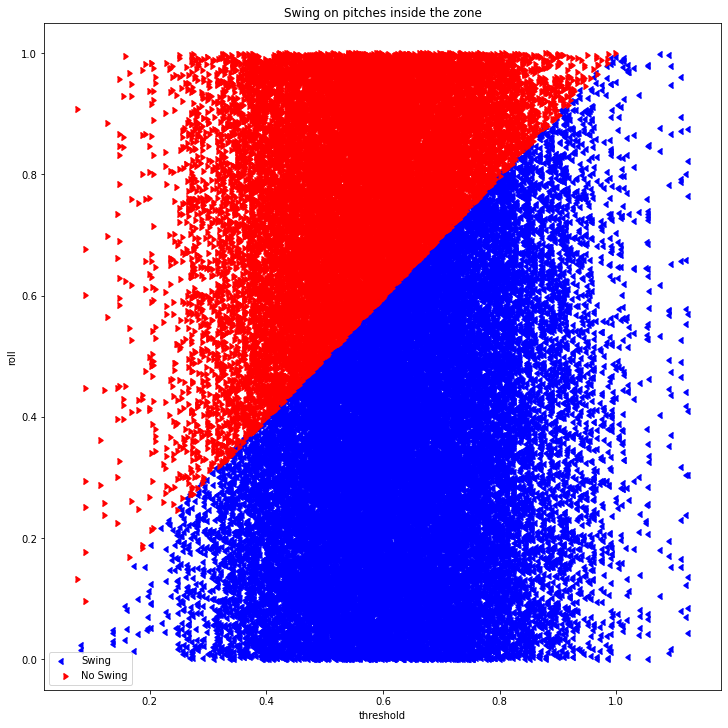

In [5]:
# dfc["threshold"] = -1*(\
#     intercept_scaled + \
#     coef_scaled[0,1] * dfc["combined_batting"] + \
#     coef_scaled[0,2] * dfc["pitcher_ruth_with_vibe"] + \
#     coef_scaled[0,3] * dfc["ballpark_viscosity"])


dfc["threshold"] = (
    0.70
    + 0.35 * dfc["combined_batting"]
    - 0.40 * dfc["pitcher_ruth_with_vibe"]
    + 0.20 * (dfc["ballpark_viscosity"] - 0.5)
)

# [(1.0, 'roll'),
#  (0.3998948107488037, 'pitcher_ruth_with_vibe'),
#  (-0.3493653911192097, 'combined_batting'),
#  (-0.19858215226781548, 'ballpark_viscosity')]
# array([-0.6006551])


x_val = "threshold"
# x_val = "invpath_with_vibe"
fig, ax = plt.subplots(1, figsize=(10, 10), layout="constrained")
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Swing",
    marker=CARETLEFTBASE,
)
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="No Swing",
    marker=CARETRIGHTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title("Swing on pitches inside the zone")
# ax.set_xlim(0.484, 0.499)

ax.legend()

1


,event_type,offset,roll,threshold,pitcher_mul,batter_mul,baserunner_count,pitcher_ruth_with_vibe,invpath_with_vibe,ballpark_viscosity,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count,weather
57780,StrikeSwinging,0.386562,0.839846,0.453283,1.0,1.0,0,1.048943,0.750816,0.432771,Yrjö Kerfuffle,Hiroto Wilcox,NaN,FRIEND_OF_CROWS,PARTY_TIME,FIREPROOF;SEALANT;AMBUSH,93,480079a6-7cd8-44c6-a887-6540eee0a950,158,Weather.PEANUTS


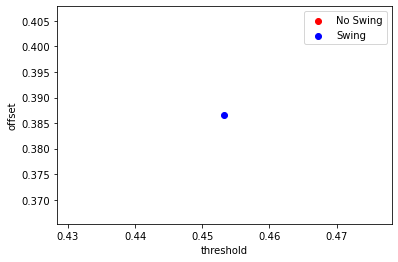

In [6]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="No Swing",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Swing",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

table = outliers
print(len(table))
table = table[
    [
        "event_type",
        "offset",  # "home_score", "away_score", "top_of_inning", "inning",
        "roll",
        "threshold",
        "pitcher_mul",
        "batter_mul",
        "baserunner_count",
        #        "batter_vibes", "pitcher_vibes",
        "pitcher_ruth_with_vibe",
        "invpath_with_vibe",
        "ballpark_viscosity",
        # "batter_musclitude", "batter_divinity", "batter_thwackability", "batter_patheticism",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "day",
        "game_id",
        "play_count",
        "weather",
    ]
].sort_values("offset", ascending=False)
# len(table)
# print(table['offset']/table['threshold'])
table

In [7]:
# 45416, 23524, 4836
# out1 = dfc.loc[
#     # 207244,
#     # 209536,
#     # 207434,
#     201686,
#     [
#         "event_type",
#         "passed",
#         "offset",
#         "home_score",
#         "away_score",
#         "top_of_inning",
#         "inning",
#         "roll",
#         "threshold",
#         "pitcher_mul",
#         "batter_mul",
#         "baserunner_count",
#         "batter_vibes",
#         "pitcher_vibes",
#         "pitcher_ruth_with_vibe",
#         "invpath_with_vibe",
#         "ballpark_viscosity",
#         "batter_musclitude",
#         "batter_divinity",
#         "batter_thwackability",
#         "batter_patheticism",
#         "combined_batting",
#         "batter_name",
#         "pitcher_name",
#         "batter_mods",
#         "pitcher_mods",
#         "batting_team_mods",
#         "pitching_team_mods",
#         "day",
#         "weather",
#         "game_id",
#         "play_count",
#     ],
# ]
# out1

In [8]:
# dfc["threshold"] = -1*(\
#     -0.60 + \
#     -0.35 * dfc["combined_batting"] + \
#     0.40 * dfc["pitcher_ruth_with_vibe"] + \
#     -0.20 * dfc["ballpark_viscosity"])

# df["invpath"] = 1 - df["batter_patheticism"] / df["batter_mul"]
# df["invpath_mul"] = df["invpath"]  # / df['batter_mul']
# df["invpath_with_vibe"] = df["invpath_mul"] * (1 + 0.2 * df["batter_vibes"])
# df["combined_batting"] = 0.25 * (
#     df["batter_div_with_vibe"]
#     + df["batter_musc_with_vibe"]
#     + df["invpath_with_vibe"]
#     + df["batter_thwack_with_vibe"]
# )

# musc0 = out1["batter_musclitude"] / out1["batter_mul"]
# div0 = out1["batter_divinity"] / out1["batter_mul"]
# thwack0 = out1["batter_thwackability"] / out1["batter_mul"]
# path0 = out1["batter_patheticism"]

# (
#     0.60
#     + 0.20 * out1["ballpark_viscosity"]
#     - 0.40 * out1["pitcher_ruth_with_vibe"]
#     + 0.35 * 0.25 * (1 + 0.2 * out1["batter_vibes"]) * (musc0 + div0 + thwack0 + (1 - path0))
# )

In [9]:
# print(out1["roll"])
# print(out1["threshold"])

In [10]:
# non_batting_terms = 0.60 + 0.20 * out1["ballpark_viscosity"] - 0.40 * out1["pitcher_ruth_with_vibe"]
# non_batting_terms

In [11]:
# multest = 1.16
# batting_term = (
#     0.35
#     * 0.25
#     * (1 + 0.2 * out1["batter_vibes"])
#     * (musc0 * multest + div0 * multest + thwack0 * multest + (1 - path0 / 1)))
# print("batting term:",batting_term)
# print( "threshold:   ", non_batting_terms + batting_term)
# print("roll:        ", out1["roll"])
# print("offset:      ", out1["roll"] - (non_batting_terms + batting_term))

In [12]:
# print(out1["combined_batting"])
# print(batting_term/0.35)

In [13]:
table.groupby("pitching_team_mods").size()

pitching_team_mods
FIREPROOF;SEALANT;AMBUSH    1
dtype: int64

In [14]:
table.groupby("batting_team_mods").size()

batting_team_mods
PARTY_TIME    1
dtype: int64

In [15]:
table.groupby("batter_mods").size()

Series([], dtype: int64)

In [16]:
table.groupby("pitcher_mods").size()

pitcher_mods
FRIEND_OF_CROWS    1
dtype: int64

In [17]:
# X = dfc[['roll', 'passed',
#         'batter_div_with_vibe', 'batter_musc_with_vibe', 'batter_patheticism', 'batter_thwack_with_vibe',
#         'pitcher_ruth_with_vibe', 'ballpark_viscosity']]
# X = dfc[['roll', 'passed',
#         'batter_div_with_vibe', 'batter_musc_with_vibe', 'invpath_with_vibe', 'batter_thwack_with_vibe',
#         'pitcher_ruth_with_vibe', 'ballpark_viscosity']]
X = dfc[
    [
        "roll",
        "passed",
        "combined_batting",
        "pitcher_ruth_with_vibe",
        "ballpark_viscosity",
    ]
]
# X = X[X['roll'] < 0.85]

# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]
y = X["passed"]
X = X.drop("passed", axis=1)

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=10000000, tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))

[[20449     8]
 [    5 31155]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     20457
        True       1.00      1.00      1.00     31160

    accuracy                           1.00     51617
   macro avg       1.00      1.00      1.00     51617
weighted avg       1.00      1.00      1.00     51617



In [19]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[(1.0, 'roll'),
 (0.3994046063439128, 'pitcher_ruth_with_vibe'),
 (-0.34876564183818215, 'combined_batting'),
 (-0.20249287951017453, 'ballpark_viscosity')]

In [20]:
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
intercept_scaled

array([-0.59933217])

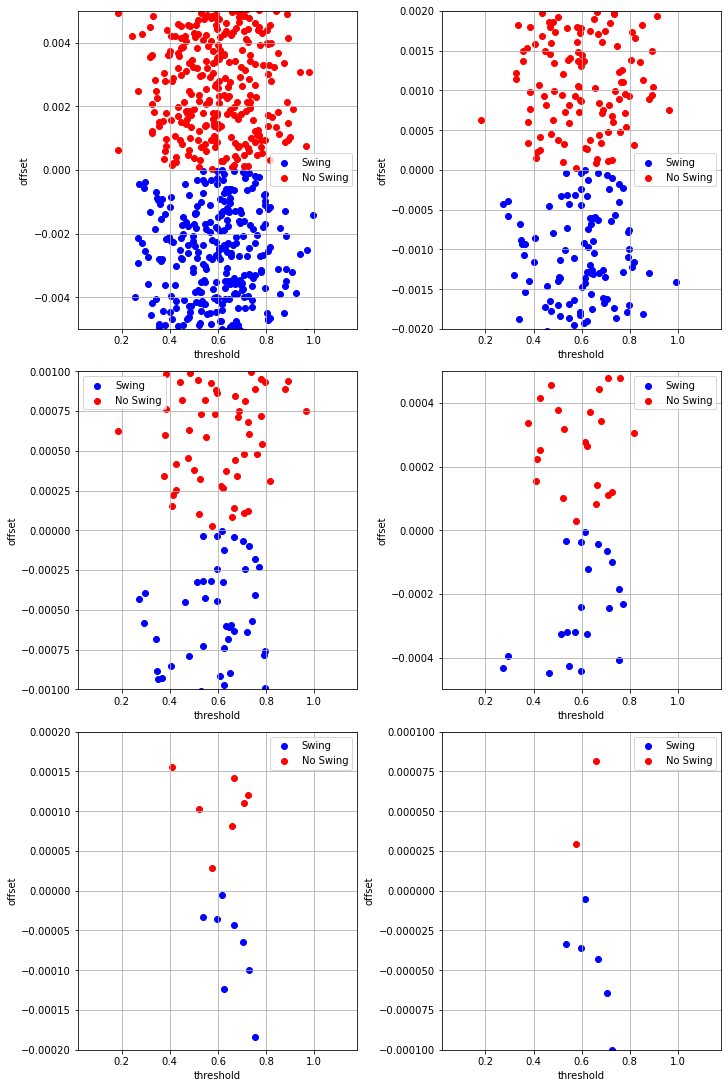

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15), layout="constrained")
dimlist = [5e-3, 2e-3, 1e-3, 0.5e-3, 0.2e-3, 0.1e-3]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Swing",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="No Swing",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="yellow",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="yellow",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    # ax.set_yscale("log")
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("../figures/swing_strike_fit_offsets.png", facecolor='white')

In [22]:
# list(df.columns)